* By: Rino Hilman
* Email: rinohilman@yahoo.com
* Reference: Detection of False Investment Strategies using Unsupervised Learning Methods by Marcos Lopez de Prado and Michael J. Lewis 




# Optimal Number of Clusters (ONC)

* Warning : written for python 3


## Introduction

Optimal Number of Clusters algorithm has a purpose to detect optimal number of K-Means clusters using feature correlation matrix and silhouette scores.
This implementation is based on 'Detection of False Investment Strategies using Unsupervised Learning Methods' https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3167017

The result of this algorithm is a tupple that contains:

    Correlation Matrix
    Optimized Clusters
    Silhouette Scores

Correlation Matrix show the matrix that are sorted by their relevance. Optimized Clustres show the optimal number of clustres and each of the culsters' contents.


## Purpose

This notebook shows the modified K-Means clustering or known as ONC algorithm preceded by a random correlation matrix generator and the original K-means clustering process. The notebook shows the uniqueness of ONC in comparison to the original K-means clustering algorithm.

## Exercises

The exercises contain the working codes that represent the ONC algorithm ,the random correlation matrix generator, and the original K-means clustering steps. All codes can be executed and will work accordingly. The first step is to import all of the necessary packages.

In [469]:
import numpy as np
import pandas as pd 
from scipy.linalg import block_diag 
from sklearn.utils import check_random_state 

## Random Correlation Block - Matrices Algorithm

A function getCovSub has a purpose to find the Sub Covariance Matrix

In [470]:
def getCovSub(nObs,nCols,sigma,random_state=None): 
    # Sub covariance matrix 
    rng = check_random_state(random_state) 
    if nCols==1:return np.ones((1,1)) 
    ar0=rng.normal(size=(nObs,1))     
    ar0=np.repeat(ar0,nCols,axis=1)     
    ar0+=rng.normal(scale=sigma,size=ar0.shape)     
    ar0=np.cov(ar0,rowvar=False)     
    return ar0

The function getRndBlockCov generates a random covariance matrix with a given number of blocks

In [471]:
def getRndBlockCov(nCols,nBlocks,minBlockSize=1,sigma=1.,random_state=None):
    # Generate a random covariance matrix with a given number of blocks     
    rng = check_random_state(random_state)     
    parts=rng.choice(range(1,nCols-(minBlockSize-1)*nBlocks),nBlocks-1,replace=False)     
    parts.sort()     
    parts=np.append(parts,nCols-(minBlockSize-1)*nBlocks)     
    parts=np.append(parts[0],np.diff( parts )) - 1 + minBlockSize     
    cov=None     
    for nCols_ in parts:         
        cov_=getCovSub(int(max(nCols_*(nCols_+1)/2.,100)),nCols_,sigma,random_state=rng)         
        if cov is None:cov=cov_.copy()         
        else:cov=block_diag(cov,cov_)     
    return cov 

The function cov2corr transforms covariance into correlation matrix

In [472]:
def cov2corr(cov):     
    # Derive the correlation matrix from a covariance matrix     
    std=np.sqrt(np.diag(cov))     
    corr=cov/np.outer(std,std)     
    corr[corr<-1],corr[corr>1]=-1,1 # numerical error     
    return corr 

The function randomBlockCorr forms the random block correlation 

In [473]:
def randomBlockCorr(nCols,nBlocks,random_state=None,minBlockSize=1):     
    # Form block correlation    
    rng = check_random_state(random_state)     
    cov0=getRndBlockCov(nCols,nBlocks,minBlockSize=minBlockSize,\
                        sigma=.5,random_state=rng) # perfect block corr     
    cov1=getRndBlockCov(nCols,1,minBlockSize=minBlockSize,\
                        sigma=1.,random_state=rng) # add noise     
    cov0+=cov1     
    corr0=cov2corr(cov0)     
    corr0=pd.DataFrame(corr0)     
    return corr0

## Execution of the Random Correlation Block - Matrices Algorithm

Set predetermined variables for the algorithm. These values are generated randomly according to necessities.

In [474]:
import random
nBlocks1 = random.randint(1,10)
nCols1= random.randint(nBlocks1,10)

Execute the randomBlockCorr function to create a random correlation matrix.

In [475]:
#randomBlockCorr(nCols,nBlocks,random_state=None,minBlockSize=1)
corr0A=randomBlockCorr(nCols1,nBlocks1,random_state=None,minBlockSize=1)

The random correlation matrix is available below:

In [476]:
corr0A

,0,1,2,3,4,5,6,7,8
0,1.000000,0.238406,0.260600,0.292942,0.284208,0.285883,0.317745,0.282019,0.265038
1,0.238406,1.000000,0.348245,0.349079,0.284037,0.333729,0.263823,0.302180,0.235372
2,0.260600,0.348245,1.000000,0.367391,0.236412,0.285744,0.308991,0.342733,0.212146
3,0.292942,0.349079,0.367391,1.000000,0.361297,0.272781,0.290896,0.279618,0.263238
4,0.284208,0.284037,0.236412,0.361297,1.000000,0.529773,0.262393,0.313142,0.219888
5,0.285883,0.333729,0.285744,0.272781,0.529773,1.000000,0.279904,0.207030,0.235409
6,0.317745,0.263823,0.308991,0.290896,0.262393,0.279904,1.000000,0.324437,0.273005
7,0.282019,0.302180,0.342733,0.279618,0.313142,0.207030,0.324437,1.000000,0.244495
8,0.265038,0.235372,0.212146,0.263238,0.219888,0.235409,0.273005,0.244495,1.000000


Create a heatmap of the correlation data.

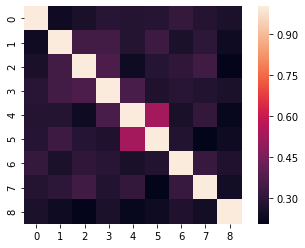

In [477]:
import seaborn as sns
sns.heatmap(corr0A, square = True)

## Execution of the ONC Clustering Algorithm

Execute the ONC Clustering Algorithm that yields in: 

* Correlation Matrix
* Optimized Clusters
* Silhouette Scores

In [478]:
from mlfinlab.clustering.onc import get_onc_clusters # import the ONC function

In [479]:
data2 = get_onc_clusters(corr0A,10)

In [480]:
data2

(          0         4         5         8         1         2         3  \
 0  1.000000  0.284208  0.285883  0.265038  0.238406  0.260600  0.292942   
 4  0.284208  1.000000  0.529773  0.219888  0.284037  0.236412  0.361297   
 5  0.285883  0.529773  1.000000  0.235409  0.333729  0.285744  0.272781   
 8  0.265038  0.219888  0.235409  1.000000  0.235372  0.212146  0.263238   
 1  0.238406  0.284037  0.333729  0.235372  1.000000  0.348245  0.349079   
 2  0.260600  0.236412  0.285744  0.212146  0.348245  1.000000  0.367391   
 3  0.292942  0.361297  0.272781  0.263238  0.349079  0.367391  1.000000   
 6  0.317745  0.262393  0.279904  0.273005  0.263823  0.308991  0.290896   
 7  0.282019  0.313142  0.207030  0.244495  0.302180  0.342733  0.279618   
 
           6         7  
 0  0.317745  0.282019  
 4  0.262393  0.313142  
 5  0.279904  0.207030  
 8  0.273005  0.244495  
 1  0.263823  0.302180  
 2  0.308991  0.342733  
 3  0.290896  0.279618  
 6  1.000000  0.324437  
 7  0.324437 

The new dataframe that was clustered by the algorithm is structured based on the clustering of the correlation numbers.

In [481]:
datatest= data2[0]
datatest

,0,4,5,8,1,2,3,6,7
0,1.000000,0.284208,0.285883,0.265038,0.238406,0.260600,0.292942,0.317745,0.282019
4,0.284208,1.000000,0.529773,0.219888,0.284037,0.236412,0.361297,0.262393,0.313142
5,0.285883,0.529773,1.000000,0.235409,0.333729,0.285744,0.272781,0.279904,0.207030
8,0.265038,0.219888,0.235409,1.000000,0.235372,0.212146,0.263238,0.273005,0.244495
1,0.238406,0.284037,0.333729,0.235372,1.000000,0.348245,0.349079,0.263823,0.302180
2,0.260600,0.236412,0.285744,0.212146,0.348245,1.000000,0.367391,0.308991,0.342733
3,0.292942,0.361297,0.272781,0.263238,0.349079,0.367391,1.000000,0.290896,0.279618
6,0.317745,0.262393,0.279904,0.273005,0.263823,0.308991,0.290896,1.000000,0.324437
7,0.282019,0.313142,0.207030,0.244495,0.302180,0.342733,0.279618,0.324437,1.000000


The new matrix heatmap is plotted. 

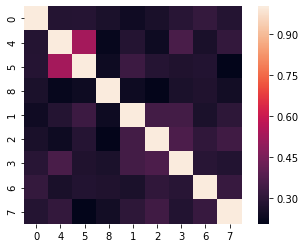

In [482]:
import seaborn as sns
sns.heatmap(datatest, square = True)

Scatter plot for matrix.

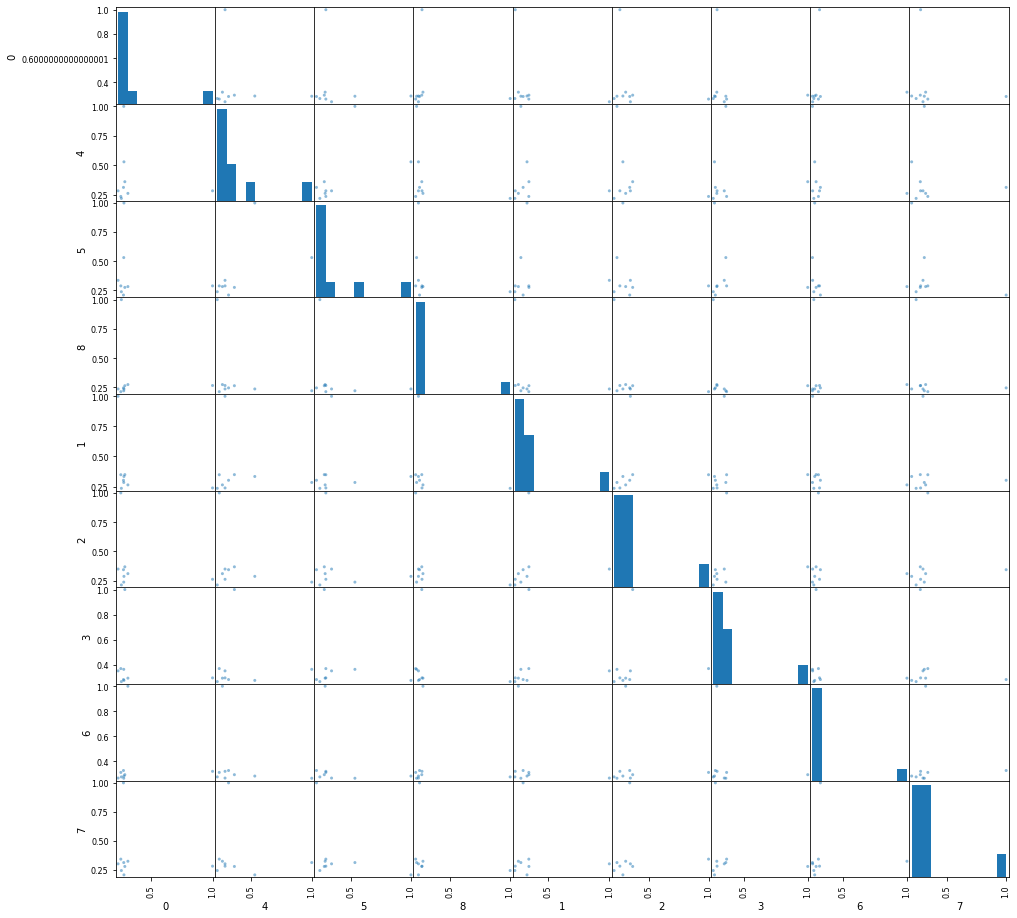

In [483]:
pd.plotting.scatter_matrix(datatest, figsize=(16, 16))
plt.show()

## Clustering through K-means clustering

Determine the number of k. In this case we choose elbow method to determine k.

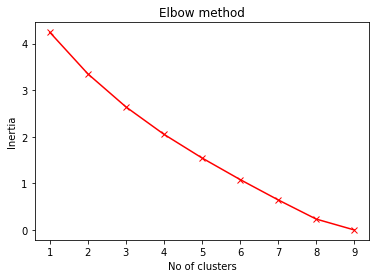

In [486]:
Inertia =[]
for i in range(1, 10):
    kmeans = KMeans(n_clusters = i).fit(corr0A)
    kmeans.fit(corr0A)
    Inertia.append(kmeans.inertia_)
    
import matplotlib.pyplot as plt
plt.plot(range(1, 10), Inertia, 'rx-')
plt.title('Elbow method')
plt.xlabel('No of clusters')
plt.ylabel('Inertia')
plt.show()

We eyeball the graph to find k. In this case, 3, as the k, is the point after which the distortion/inertia starts to decrease in a linear fashion. Use the k as the number of clusters for K-means clustering.

In [487]:
Kmean = KMeans(n_clusters=3)
listest = Kmean.fit_predict(corr0A)
listest

array([0, 2, 2, 2, 1, 1, 0, 2, 0])

The clustering of the matrix correlation numbers result in unique numbers that represent the clustering groups for each of the index positioning values. Each cluster is labeled by the k unique numbers which consists of the index numbers that is labeled by these unique cluster label numbers.

In [492]:
j = [x for _, x in sorted(zip(listest,corr0A.index))] 
j

[0, 6, 8, 4, 5, 1, 2, 3, 7]

New matrix based on clustering is formed below.

In [489]:
dfB = corr0A[j]
dfC = dfB.reindex(j)
dfC

,0,6,8,4,5,1,2,3,7
0,1.000000,0.317745,0.265038,0.284208,0.285883,0.238406,0.260600,0.292942,0.282019
6,0.317745,1.000000,0.273005,0.262393,0.279904,0.263823,0.308991,0.290896,0.324437
8,0.265038,0.273005,1.000000,0.219888,0.235409,0.235372,0.212146,0.263238,0.244495
4,0.284208,0.262393,0.219888,1.000000,0.529773,0.284037,0.236412,0.361297,0.313142
5,0.285883,0.279904,0.235409,0.529773,1.000000,0.333729,0.285744,0.272781,0.207030
1,0.238406,0.263823,0.235372,0.284037,0.333729,1.000000,0.348245,0.349079,0.302180
2,0.260600,0.308991,0.212146,0.236412,0.285744,0.348245,1.000000,0.367391,0.342733
3,0.292942,0.290896,0.263238,0.361297,0.272781,0.349079,0.367391,1.000000,0.279618
7,0.282019,0.324437,0.244495,0.313142,0.207030,0.302180,0.342733,0.279618,1.000000


Correlation heatmap is drawn.

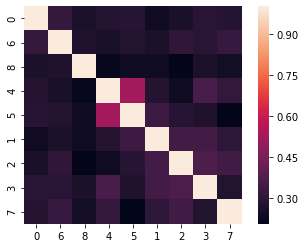

In [490]:
import seaborn as sns
sns.heatmap(dfC, square = True)

Scatter plot for matrix.

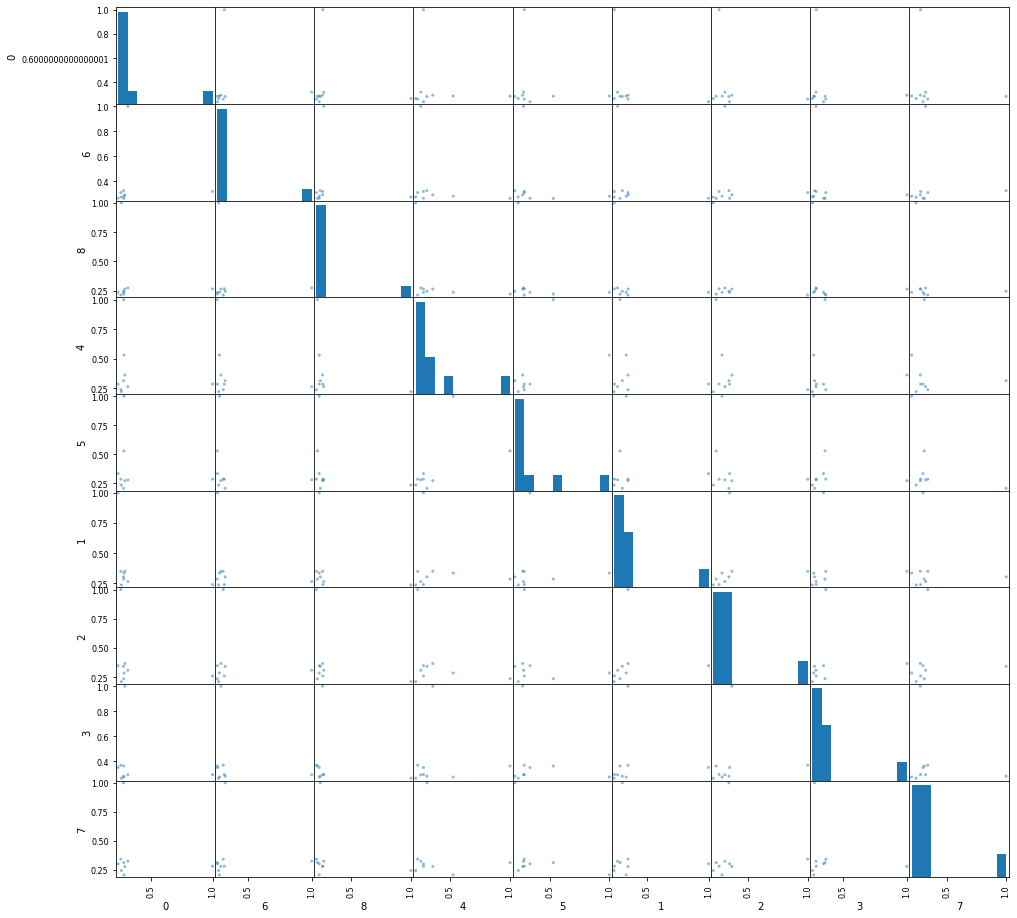

In [491]:
pd.plotting.scatter_matrix(dfC, figsize=(16, 16))
plt.show()

## Conclusion

The ONC algorithm will result in the optimum clustering of its input correlation values. The k value is calculated automatically with this algorithm. Silhouette scores are also provided by this algorithm for each of the correlation numbers. The scores should give a better positioning of relationships among the correlations with their clusters.